In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, Dense, MultiHeadAttention, LayerNormalization, Dropout, Flatten, BatchNormalization, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [22]:
# Load the dataset
data = pd.read_csv('C:\\Users\\meera\\Documents\\BTech CSE spl. AIML\\VS code\\CADS Internship\\Turbine Dataset SCADA.csv')
data['Date/Time'] = pd.to_datetime(data['Date/Time'], format='%d %m %Y %H:%M')
data.set_index('Date/Time', inplace=True)

In [23]:
# Feature selection
features = ['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
target = 'LV ActivePower (kW)'

In [24]:
# Handle missing values
data.dropna(inplace=True)

# Detect and handle outliers using clipping
def clip_outliers(df, column, lower_quantile=0.01, upper_quantile=0.99):
    lower_bound = df[column].quantile(lower_quantile)
    upper_bound = df[column].quantile(upper_quantile)
    df[column] = np.clip(df[column], lower_bound, upper_bound)

# Clipping outliers in features and target
for col in features + [target]:
    clip_outliers(data, col)

In [25]:
# Normalize the data
scaler = MinMaxScaler()
data[features + [target]] = scaler.fit_transform(data[features + [target]])

In [26]:
# Convert to supervised learning problem
def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 24  # Example sequence length (e.g., 24 hours)
X, y = create_sequences(data[features].values, data[target].values, seq_length)

In [27]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Model architecture with dropout and batch normalization
inputs = Input(shape=(seq_length, len(features)))
x = Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
x = BatchNormalization()(x)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = GRU(50, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(25, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

In [47]:
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 24, 3)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 23, 64)            448       
                                                                 
 batch_normalization_1 (Bat  (None, 23, 64)            256       
 chNormalization)                                                
                                                                 
 lstm_2 (LSTM)               (None, 23, 50)            23000     
                                                                 
 dropout_4 (Dropout)         (None, 23, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 23, 50)            15300     
                                                           

In [58]:
# Model training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/10
1011/1011 [==============================] - 21s 21ms/step - loss: 0.0183 - val_loss: 0.0142 - lr: 0.0010
Epoch 2/10
1011/1011 [==============================] - 22s 22ms/step - loss: 0.0184 - val_loss: 0.0138 - lr: 0.0010
Epoch 3/10
1011/1011 [==============================] - 23s 23ms/step - loss: 0.0181 - val_loss: 0.0136 - lr: 0.0010
Epoch 4/10
1011/1011 [==============================] - 23s 22ms/step - loss: 0.0179 - val_loss: 0.0152 - lr: 0.0010
Epoch 5/10
1011/1011 [==============================] - 23s 23ms/step - loss: 0.0176 - val_loss: 0.0160 - lr: 0.0010
Epoch 6/10
1011/1011 [==============================] - 24s 23ms/step - loss: 0.0171 - val_loss: 0.0145 - lr: 0.0010
Epoch 7/10
1011/1011 [==============================] - 23s 23ms/step - loss: 0.0163 - val_loss: 0.0135 - lr: 5.0000e-04
Epoch 8/10
1011/1011 [==============================] - 24s 23ms/step - loss: 0.0163 - val_loss: 0.0129 - lr: 5.0000e-04
Epoch 9/10
1011/1011 [==============================] - 

In [59]:
# Model evaluation
predicted = model.predict(X_test)

316/316 [==============================] - 2s 6ms/step


In [60]:
# Checking for small actual values
small_value_threshold = 0.01
small_values = np.sum(y_test < small_value_threshold)
total_values = len(y_test)
print(f'Number of small actual values (< {small_value_threshold}): {small_values} out of {total_values}')

# Handling negative predictions by setting them to zero
predicted = np.maximum(predicted, 0)

Number of small actual values (< 0.01): 2406 out of 10102


In [61]:
# Evaluation metrics
mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted)
r2 = r2_score(y_test, predicted)
msle = mean_squared_log_error(y_test, predicted)

In [62]:
# Output the results
print("Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Logarithmic Error (MSLE): {msle}")

Model Evaluation Metrics:
Mean Squared Error (MSE): 0.01324718992724535
Root Mean Squared Error (RMSE): 0.1150964375089227
Mean Absolute Error (MAE): 0.06293366520745632
R-squared (R²): 0.8986227739885965
Mean Squared Logarithmic Error (MSLE): 0.00691951473618297


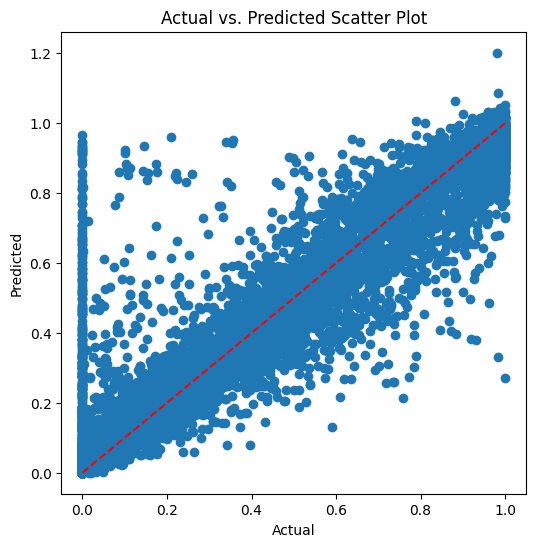

In [63]:
# Visualizing results
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predicted)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Scatter Plot')
plt.show()

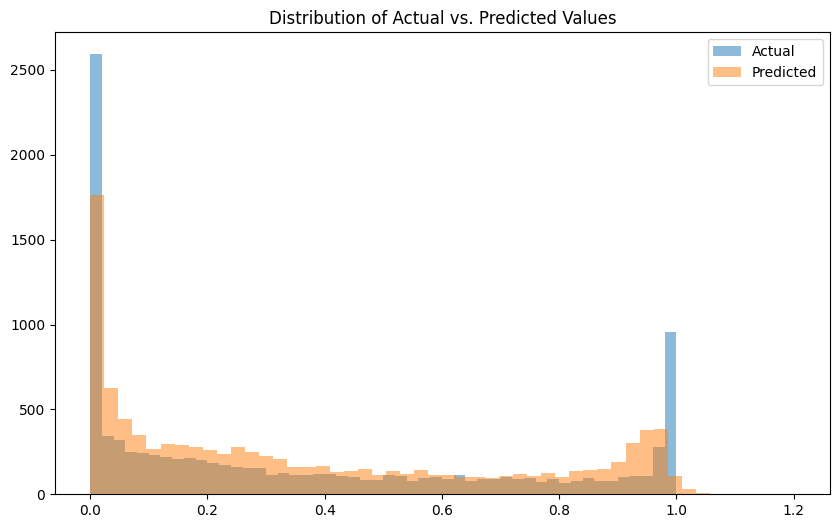

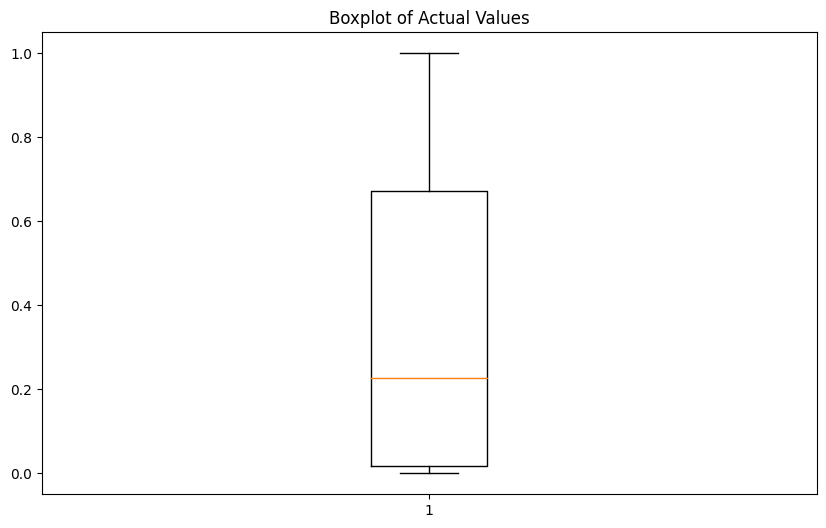

In [64]:
# Checking the distribution of actual and predicted values
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=50, alpha=0.5, label='Actual')
plt.hist(predicted, bins=50, alpha=0.5, label='Predicted')
plt.legend()
plt.title('Distribution of Actual vs. Predicted Values')
plt.show()

# Checking for outliers in the actual values
plt.figure(figsize=(10, 6))
plt.boxplot(y_test)
plt.title('Boxplot of Actual Values')
plt.show()

Negative values in inverse transformed y_test: False
Negative values in inverse transformed predicted: False


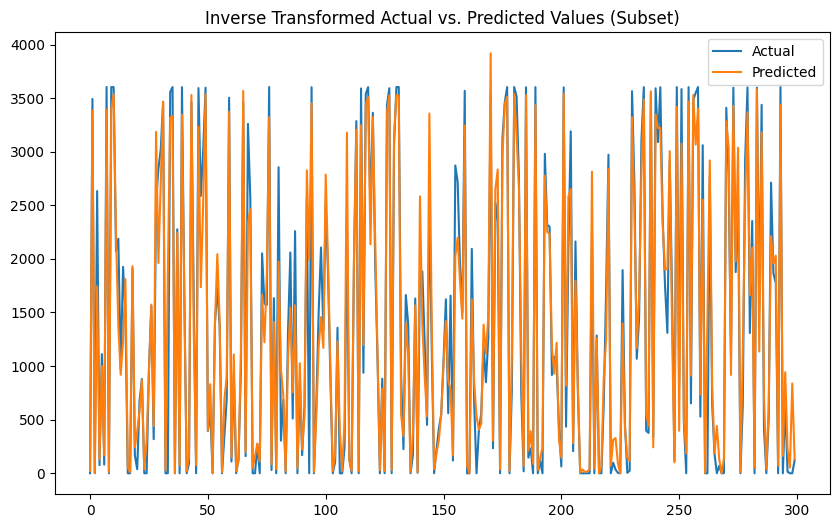

In [68]:
# Inverse transform the target variable if it was scaled
y_test_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), len(features))), y_test.reshape(-1, 1)], axis=1))[:, -1]
predicted_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(predicted), len(features))), predicted.reshape(-1, 1)], axis=1))[:, -1]

# Checking for negative values in the inverse transformed predictions
print(f'Negative values in inverse transformed y_test: {np.any(y_test_inv < 0)}')
print(f'Negative values in inverse transformed predicted: {np.any(predicted_inv < 0)}')

# Plotting the inverse transformed actual vs. predicted values (subset for clarity)
subset_size = 300  # Adjust this to plot a manageable subset for clarity
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv[:subset_size], label='Actual')
plt.plot(predicted_inv[:subset_size], label='Predicted')
plt.legend()
plt.title('Inverse Transformed Actual vs. Predicted Values (Subset)')
plt.show()

In [69]:
model.save('hybrid_model.h5')

C:\Users\meera\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
